# Neural networks with PyTorch 使用Pytorch实现神经网络

深度学习网络就是有成百上千的神经层构成了，因为有很多很多层，所以才称之为<深度>。你能够像上文一样，只用一个权重矩阵就能够实现构建网络，但是在现实中，这么做非常的困难。在Pytorch中，`nn`模块提供了一个高效构建网络的接口。


In [0]:
# 下载必要数据
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py', 'helper.py')

('helper.py', <http.client.HTTPMessage at 0x7fdd85cac8d0>)

In [0]:
# 导入必要的模块

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch

import helper

import matplotlib.pyplot as plt


现在我们来构建一个大型网络来解决手写输入的识别问题。这里我们使用的MNIST数据库，里面的图片为28x28灰度手写数字，如下图所示。

<img src='https://github.com/yangliuav/deep-learning-with-pytorch-Chinese-version/blob/master/intro-to-pytorch/assets/mnist.png?raw=1'>

我们的目标就是构建一个神经网络，进而完成手写的识别。

第一，我们需要下载数据，下面的代码可能有点复杂，我们后续会相应的解释，请不要放弃。


In [0]:
### 先下载数据

from torchvision import datasets, transforms

# 定义一个tranform（变换）来对数据进行归一化
 
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# 下载数据
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 9243688.96it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 140088.73it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2324229.35it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 52135.96it/s]            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


我们先将训练数据加载到`trainloader`，并设置一个迭代器`iter(trainloader)`，随后我们用这个迭代器来遍历训练数据，这个过程有点类似于，

```python
for image, label in trainloader:
    ## do things with images and labels
```
注意，`trainloader`的batch（批量）大小为64且`shuffle=True`。
batch 大小:每次循环我们加载图片的数目。每次循环（运行一次网络）被称为一个*batch*。
`shuffle=True`：每次加载数据，都会对数据进行打乱操作，这样有助于增加鲁棒性。
这里为了演示方便，我们先知进行一次迭代，我们可以看到`images`张量的size为`(64, 1, 28, 28)`，其中
64：每batch的加载64images。
1： 一个颜色通道（灰度）。
28x28：图像大小。


In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


我们加载一副图像看一看他的样子。

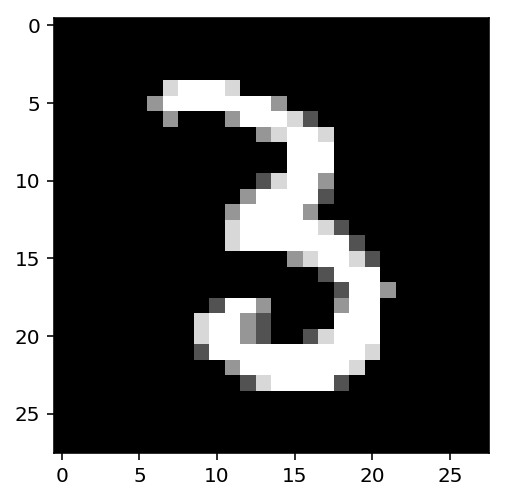

In [0]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r'); # squeeze（）函数将表示向量的数组转换为秩为1的数组

我们先尝试使用权重矩阵和矩阵乘法构建一个简单的神经网路。在本文中，我们使用方便且强大的`nn`模块。

到现在为止，我们构建的网络都是*全链接*网络或称之为*稠密*网路。也就是说，每个神经元（单元）都和下一层的每一个神经元都连接（有权非0）。在全连接网络中，每层输入必需是一维向量（因为会迭代多次，所以输入可以拼接成一个2D矩阵）。但是，因为我们的图像是一个28x28 二维张量，所以我们需要将他转化为一个一维向量。考虑到尺寸问题，我们将一个batch的图像由`(64, 1, 28, 28)`转换为`(64, 784)`（注：784= 28 * 28）。截止到目前为止我们完成了*展平*操作。

现在我们已经有了一个完整的学习网络，这里我们要区分10个数字，所以网络输出为一个 1* 10的向量，每个元素的值为每个数字的概率。拥有最高概率的数字就是我们预测的数字。


> **练习：** 展平一批图像`images`。然后使用随机权重和偏移量来构建一个神经网络。它是一个具有784个输入单元，256个隐藏单元和10个输出单元的多层网络。对于隐藏层，我们使用sigmoid激活。为了让输出层输出概率值，我们不对输出进行激活操作。

In [0]:
## 解
def activation(x):
    return 1/(1+torch.exp(-x))

# 展平数据
inputs = images.view(images.shape[0], -1)

# 创建参数
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 10)
b2 = torch.randn(10)

h = activation(torch.mm(inputs, w1) + b1)

out = torch.mm(h, w2) + b2

**Now** 现在我们网络有了一个10个输入。每个输入网络的图像都能得到一个概率分布来告诉我们图像里的数字是什么。我们来举个例子：

<img src='https://github.com/yangliuav/deep-learning-with-pytorch-Chinese-version/blob/master/intro-to-pytorch/assets/image_distribution.png?raw=1' width=500px>

这里我们会发现每个类别的概率似乎差的不多，这是因为我们的网络还没有训练，而且起始的参数是随机的分布值。这里计算概率我们用的是[**softmax** function](https://en.wikipedia.org/wiki/Softmax_function)数学表达式为：
$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$

这里， $x_i$取值范围为0到1，这个公式其实还完成了归一化的操作，使所有概率的和为一。

> **练习:** 实现一个`softmax`函数，来算并返回批处理中每个例子的概率分布。你需要注意，执行此操作时张量的大小变化。如果你有一个张量`a`大小为`(64, 10)`，还有一个张量`b`大小为`(64,)`，那么当你执行`a/b`时，就会报错，因为你的张量大小不匹配。您只想将`a`值除以一个值，你需要确保`b`的大小为`（64,1）`。 这样PyTorch会将`a`每行中的10个值除以'b`每行中的一个值。 你还需要为`torch.sum`中`dim`关键字赋值。 设置`dim = 0`取整行的总和，而'dim = 1`取整列的总和。

In [0]:
## 解
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)

# 检查一下大小，应为(64, 10)
print(probabilities.shape)
# 他们的和为一?
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000])


## 采用PyTorch构建网路

我们已经知道如何构建输出的分布了，现在我们使用PyTorch的`nn`模块来构建一个简单的网络。这里我们的网路有 784 个输入, 256 个隐藏单元， 10 个输出单元和 1 个 softmax 输出。

In [0]:
from torch import nn

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 输入和隐藏层为线性传递 
        self.hidden = nn.Linear(784, 256)
        # 隐藏层到输出层也为线性
        self.output = nn.Linear(256, 10)
        
        # 定义 sigmoid 激活函数和softmax输出函数
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # 定义前向网络的每一步操作
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

现在我们来对每一步进行一下讲解：

```python
class Network(nn.Module):
```
我们构建一个网路Network，它的父类为 `nn.Module`。使用`super().__init__()`来对父类进行初始化，这里包含了很多有用的参量（我们后续会讲）。当然这个网络你叫什么名字都可以。

```python
self.hidden = nn.Linear(784, 256)
```

定义了一个线性传递函数，$x\mathbf{W} + b$ 其中，$W$ 和 $b$ 的张量由函数自动创建，你只需要定义一个输入和输出的大小就行了。如果你想访问其中的权重和方差，你可以使用`net.hidden.weight` 和 `net.hidden.bias`。

```python
self.output = nn.Linear(256, 10)
```
同样，我们设置一个256输入，10输出的线性传递函数。
Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```
我们定义一下sigmoid 激活函数和softmax输出函数，并设置`dim=1`来对tensor每一列求和。


```python
def forward(self, x):
```
`nn.Module`有一个前向的函数函数，张量 `x` 会顺次执行`__init__`的中定义的操作。

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```
每一步的顺序要和你构建的网络相匹配，至于变量`x`的命名无关紧要。注意，网络的顺序以forward为准而不是以softmax为准，现在我们可以创建一个`Network`对象。

In [0]:
# 现在我们来定义一下这个网络
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax()
)

您可以使用`torch.nn.functional`模块更简洁明了地定义网络。为了简便，我们通常将此模块命名为`F`。



In [0]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # 输入层到隐藏层的线性连接
        self.hidden = nn.Linear(784, 256)
        # 隐藏层到输出层的线性连接
        self.output = nn.Linear(256, 10)
        
    def forward(self, x):
        # 调用F的sigmoid函数
        x = F.sigmoid(self.hidden(x))
        # 调用softmax激活函数
        x = F.softmax(self.output(x), dim=1)
        
        return x

### 激活函数

到目前为止，我们只关注softmax激活，但从理论上来讲，我们可以使用任意非线性函数来作为激活函数。常见的激活函数为：
Tanh（双曲正切函数）和ReLU（整流线性函数）。

<img src="https://github.com/yangliuav/deep-learning-with-pytorch-Chinese-version/blob/master/intro-to-pytorch/assets/activation.png?raw=1" width=700px>

在实践中，ReLU用的最为普遍。


### 构建你的网络

<img src="https://github.com/yangliuav/deep-learning-with-pytorch-Chinese-version/blob/master/intro-to-pytorch/assets/mlp_mnist.png?raw=1" width=600px>

> **练习:** 构建一个更复杂的网络，如上图所示，它经过，784个单元的输入层，128个单元的隐藏层，一个ReLU激活，64个单元的隐藏层，一个ReLU激活和一个带softmax激活的输出层。 

'fc'表示完全连接的图层。 在编写解决方案时，使用`fc1`，`fc2`和`fc3`作为图层名称。

In [0]:
## 解

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # 按图定义各层的结构
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### 初始化权重和偏移量

权重和偏移量的初始化是自动完成的，当然你也可以对他进行订制化，可通过`model.fc1.weight`来进行取值。


In [0]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[-2.3278e-02, -1.2170e-03, -1.1882e-02,  ...,  3.3567e-02,
          4.4827e-03,  1.4840e-02],
        [ 4.8464e-03,  1.9844e-02,  3.9791e-03,  ..., -2.6048e-02,
         -3.5558e-02, -2.2386e-02],
        [-1.9664e-02,  8.1722e-03,  2.6729e-02,  ..., -1.5122e-02,
          2.7632e-02, -1.9567e-02],
        ...,
        [-3.3571e-02, -2.9686e-02, -2.1387e-02,  ...,  3.0770e-02,
          1.0800e-02, -6.5941e-03],
        [ 2.9749e-02,  1.2849e-02,  2.7320e-02,  ..., -1.9899e-02,
          2.7131e-02,  2.2082e-02],
        [ 1.3992e-02, -2.1520e-02,  3.1907e-02,  ...,  2.2435e-02,
          1.1370e-02,  2.1568e-02]])
Parameter containing:
tensor(1.00000e-02 *
       [-1.3222,  2.4094, -2.1571,  3.2237,  2.5302, -1.1515,  2.6382,
        -2.3426, -3.5689, -1.0724, -2.8842, -2.9667, -0.5022,  1.1381,
         1.2849,  3.0731, -2.0207, -2.3282,  0.3168, -2.8098, -1.0740,
        -1.8273,  1.8692,  2.9404,  0.1783,  0.9391, -0.7085, -1.2522,
        -2.7769,  0

现在我们来举几个例子。


In [0]:
# 将偏移量全部赋为0
model.fc1.bias.data.fill_(0)

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [0]:
# 设为方差为1，均值为0的正态随机数
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 5.9294e-03,  9.6176e-04,  9.5034e-03,  ..., -1.2588e-03,
          3.4878e-03,  1.4495e-02],
        [-9.3127e-04, -1.0287e-02,  3.5423e-03,  ...,  1.1155e-02,
          2.5012e-03,  1.3503e-02],
        [-1.5078e-02,  8.1119e-03,  5.0678e-03,  ...,  2.8613e-03,
          9.7443e-03, -6.5530e-03],
        ...,
        [-2.2938e-03, -1.8630e-02, -4.2459e-03,  ...,  1.4718e-02,
          2.7655e-03,  3.2661e-03],
        [-3.0470e-03,  1.2617e-02, -7.9772e-03,  ..., -1.4699e-02,
         -9.1425e-03,  5.3492e-03],
        [ 2.5911e-03,  2.4797e-03, -6.1172e-03,  ...,  1.0584e-02,
         -1.0307e-02, -3.1901e-03]])

### 前相传递

我们来看一下，一幅图像通过网络有什么变化。

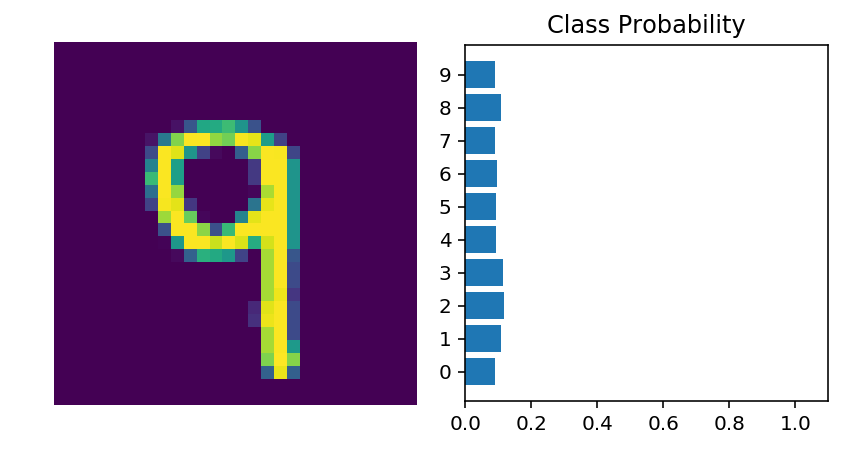

In [0]:
# 加载数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 转化为1维向量 (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# 或者 images.resize_(images.shape[0], 1, 784) 来自动获取 batch size

# 前向通过网络
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

截止到目前为止，网络还是不好用，因为所有权重都是随机地！

### 使用 `nn.Sequential`



PyTorch提供了一种方便的方法来构建网络，它叫做`nn.Sequential`` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential))。我们来看一下例子：


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax()
)


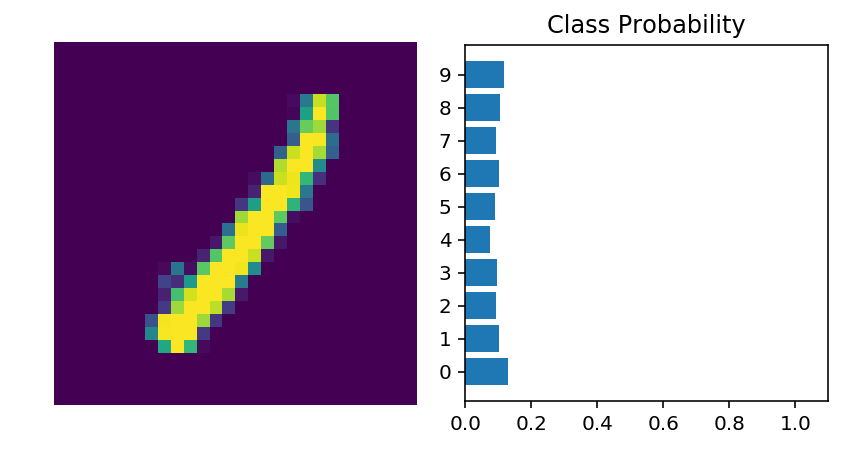

In [0]:
# 网络的超变量
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# 建立网络
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# 使数据通过网络
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
helper.view_classify(images[0].view(1, 28, 28), ps)

如果你想进行一次线性运算并查看权重，你可以使用`model[0]`。

In [0]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[-7.0372e-03,  2.9689e-02,  2.6028e-02,  ...,  1.1196e-02,
         -2.1928e-02, -3.4886e-02],
        [ 1.0624e-04, -1.6610e-02, -2.2891e-02,  ..., -6.4412e-03,
         -2.5026e-02,  1.0674e-02],
        [-2.4707e-02,  1.4146e-02,  2.0084e-02,  ...,  1.2227e-02,
          2.3441e-02, -9.5175e-03],
        ...,
        [-2.0119e-02,  7.2614e-03, -1.3481e-02,  ...,  8.1745e-03,
         -1.3348e-02, -1.1955e-02],
        [ 3.2282e-02,  1.8674e-02, -3.0826e-02,  ...,  1.7296e-02,
         -2.6710e-02, -3.0684e-02],
        [ 1.7686e-02,  3.1376e-02, -2.2645e-02,  ...,  2.4630e-02,
          3.1129e-02,  7.0939e-03]])

你甚至还可以使用一个字典`OrderedDict`来存储这些变量，这样的好处就是保证你的变量不会重名。

In [0]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax()
)

你可以使用每层的序号或者名字来快速访问他们。

In [0]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


下一篇文章我们来讲一下如何训练这个网络。